# **7. FGSM using PyTorch**
- 딥러닝을 해킹하는 적대적 공격
####<br>
- Reference의 예제 코드에서 내용 선정 및 발췌 후 정리 및 수정, 보완함
- Reference
  - 3분 딥러닝 파이토치맛

## 7-1. FGSM 공격
- 적대적 예제(Adversarial Example) : 사람이 착시를 겪듯이 정상 이미지에 노이즈를 더해 머신러닝 모델의 착시를 유도하는 입력
- 적대적 공격(Adversarial Attack) : 적대적 예제를 생성하여 여러가지 머신러닝 기반 시스템의 성능을 의도적으로 떨어뜨려 보안 문제를 일으키는 공격
####<br>
- 입력 데이터가 신경망 모델을 타고 흐르면서 계속적인 변환(갱신)이 일어나는데, 각각의 변환은 입력의 특정 구조에 매우 예민하게 반응하고 있으며, 이처럼 모델이 예민하게 반응하는 부분을 공략하여 모델을 헷갈리게 할 수 있음
- 적대적 공격은 영상 뿐만 아니라 텍스트, 오디오 등에도 적용될 수 있음
- 적대적 예제를 이용하여 자율주행 자동차가 표지판을 보지 못하게 하거나 카페에 흐르는 음악에 몰래 명령을 넣어 음성비서의 오작동을 유도하는 등 다양한 공격이 가능하며, 최근의 연구에서도 효과적인 방어법을 제시하지 못하고 있음
####<br>
- One-pixel attacks (출처: Jiawei Su, Danilo Vasconcellos Vargas and Kouichi Sakurai, One Pixel Attack for Fooling Deep Neural Networks, 17 Oct 2019, https://arxiv.org/pdf/1710.08864.pdf)

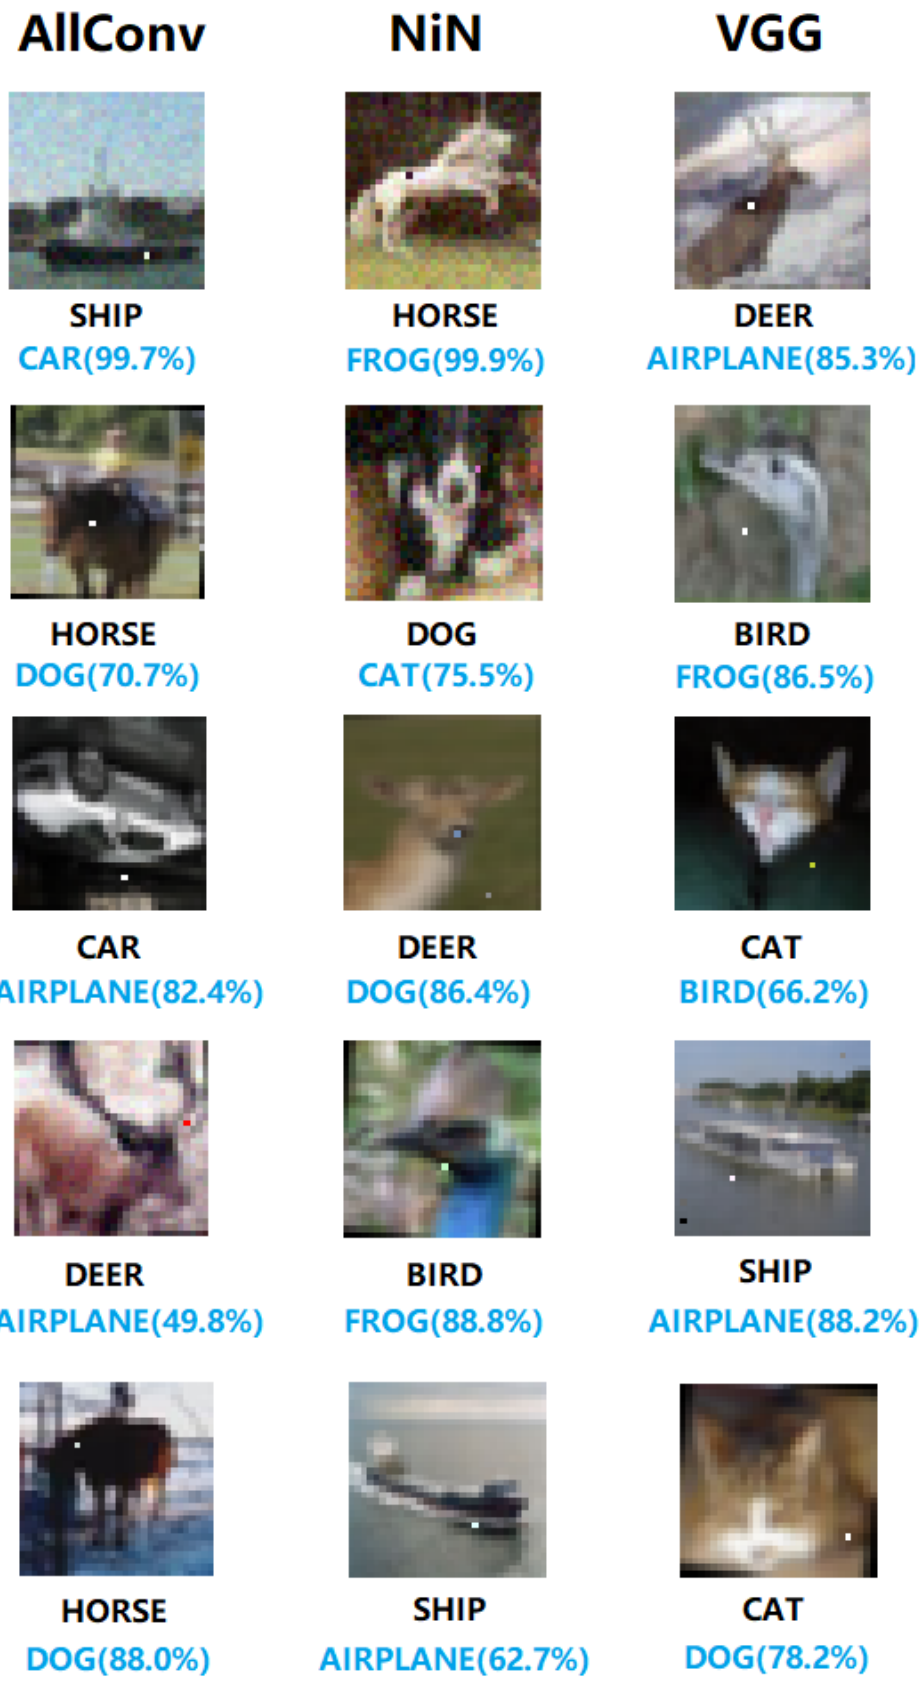

- 사람에게는 똑같이 보이면서 컴퓨터를 속이는 예제를 공부해보자.

- 적대적 예제에서의 잡음 생성 방법 (분류 기준이 무엇인가에 따라서 여러 가지로 나뉘어짐)
  - 기울기와 같은 모델 정보가 필요한지에 따라 모델 정보를 토대로 잡음을 생성하는 화이트박스 방법, 모델 정보 없이 생성하는 블랙박스 방법으로 분류
  - 원하는 정답으로 유도할 수 있다면 표적(Targeted), 그렇지 않으면 비표적(Non-Targeted)으로 분류
  - 잡음을 생성하기 위해 반복된 학습(최적화)이 필요하면 반복(Iterative), 그렇지 않으면 원샷(One-Shot)으로 분류
  - 한 잡음이 특정 입력에만 적용되는지, 모든 이미지에 적용될 수 있는 범용적인 잡음인지로 분류
####<br>
- 가장 강력한 공격 방법은
  - 모델 정보가 필요없고
  - 원하는 정답으로 유도할 수 있으며
  - 복잡한 학습이 필요하지 않고
  - 여러 모델에 동시에 적용할 수 있는 방법
- 각 특징에 따라 기회비용이 존재함
####<br>
- FGSM(Fast Gradient Sign Method)
  - 가장 간단한 방식의 공격이면서도 매우 효과적
  - 원샷 공격 방식, 비표적 방식, 화이트박스 방식
  - 이미지에 대한 기울기의 정보를 추출하여 잡음을 생성함
  - 잡음이 눈에 보이지 않아야 하므로 아주 작은 숫자를 곱해서 희석한 후, 원본 그림에 더함

- 적대적 예제가 만들어지는 과정

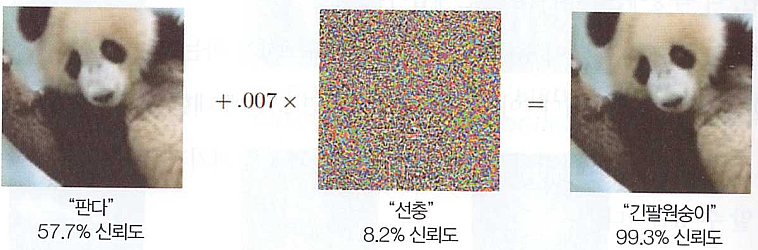

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms

from PIL import Image
import json

In [ ]:
import matplotlib.pyplot as plt

### 7-1-1. 학습된 모델 불러오기

In [ ]:
model = models.resnet101(pretrained=True)
model.eval()
print(model)

Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1,

- 데이터셋 불러오기

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
ROOT_PATH = '/gdrive/My Drive/Colab Notebooks/Lectures/data/'

In [ ]:
# idx2class 이미지넷의 클래스 정보(인덱스, 클래스명)가 담겨있는 파일을 읽어 딕셔너리로 만든 후 인덱스 번호를 레이블명(클래스명)으로 변환해주는 리스트
CLASSES = json.load(open('{}{}'.format(ROOT_PATH, 'imagenet_samples/imagenet_classes.json')))
idx2class = [CLASSES[str(i)] for i in range(1000)]

- 이미지 불러오기

In [ ]:
# 이미지 불러오기
img = Image.open('{}{}'.format(ROOT_PATH, 'imagenet_samples/corgie.jpg'))

In [ ]:
# torchvision의 transforms를 이용하여 이미지를 텐서로 변환하기
img_transforms = transforms.Compose([
    transforms.Resize((224, 224), Image.BICUBIC),
    transforms.ToTensor(),
])

img_tensor = img_transforms(img)
img_tensor = img_tensor.unsqueeze(0)      # 3 x 224 x 224 --> 1 x 3 x 224 x 224

print("이미지 텐서 모양:", img_tensor.size())

이미지 텐서 모양: torch.Size([1, 3, 224, 224])


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


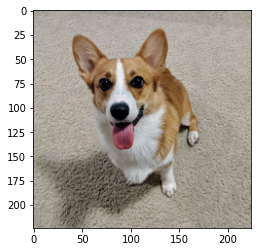

In [ ]:
# 시각화를 위해 넘파이 행렬 변환
original_img_view = img_tensor.squeeze(0).detach()  # [1, 3, 244, 244] -> [3, 244, 244]
original_img_view = original_img_view.transpose(0,2).transpose(0,1).numpy()

# 텐서 시각화
plt.imshow(original_img_view)

### 7-1-2. 공격 전 성능 확인하기


In [ ]:
output = model(img_tensor)
prediction = output.max(1, keepdim=False)[1]

prediction_idx = prediction.item()
prediction_name = idx2class[prediction_idx]

print("예측된 레이블 번호:", prediction_idx)
print("레이블 이름:", prediction_name)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


예측된 레이블 번호: 263
레이블 이름: Pembroke, Pembroke Welsh corgi


### 7-1-3.  FGSM 공격 함수 정의
- FGSM 공격의 핵심은 모델에서 입력 이미지에 대한 기울기 정보를 추출하고, 그것을 왜곡하여 원본 이미지에 더하는 것
- 기울기는 모델이 학습할 때, 각 픽셀이 미치는 영향
####<br>
- 모델을 헷갈리게 하려면 모델의 오차 값을 극대화 하여야 함
- 딥러닝 모델을 학습할 때는 기울기의 정반대 편으로 가중치를 조절하여 오차를 줄였으나, FGSM 공격에서는 반대로 잡음이 기울기의 방향으로 최적화하도록 해서 오차를 키움 $\rightarrow$ 기울기의 방향성을 알 수 있도록 sign() 함수 적용(입력이 0보다 작으면 -1, 0이면 0, 0보다 크면 1 출력)
- 매우 작은 값인 epsilon을 곱해 줌. epsilon은 학습률과 같은 개념. 잡음이 너무 커지지 않고 사람의 눈네 보이지 않게 제한하는 역할
- 결과적으로 이미지의 기울기 방향이 양수인 곳에는 epsilon만큼 값을 증가시키고 음수인 곳은 epsilon만큼 값을 감소시킴

In [ ]:
def fgsm_attack(image, epsilon, gradient):
    # 기울기값의 원소의 sign 값을 구함
    sign_gradient = gradient.sign()
    # 이미지 각 픽셀의 값을 sign_gradient 방향으로 epsilon 만큼 조절
    perturbed_image = image + epsilon * sign_gradient
    # [0,1] 범위를 벗어나는 값을 조절
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

### 7-1-4. 적대적 예제 생성

In [ ]:
# 이미지의 기울기값을 구하도록 설정
# 원본 이미지에 대한 기울기를 추출하려면 requires_grad_(True)를 호출해서 이미지에 대한 기울기를 보존하도록 명시하여야 함
img_tensor.requires_grad_(True)

# 이미지를 모델에 통과시킴
output = model(img_tensor)

# 오차값 구하기 (레이블 263은 웰시코기)
loss = F.nll_loss(output, torch.tensor([263])) 

# 기울기값 구하기
model.zero_grad()
loss.backward()

# 이미지의 기울기값을 추출
gradient = img_tensor.grad.data

# FGSM 공격으로 적대적 예제 생성
epsilon = 0.03
perturbed_data = fgsm_attack(img_tensor, epsilon, gradient)

# 생성된 적대적 예제를 모델에 통과시킴
output = model(perturbed_data)

### 7-1-5. 적대적 예제 성능 확인

In [ ]:
perturbed_prediction = output.max(1, keepdim=True)[1]

perturbed_prediction_idx = perturbed_prediction.item()
perturbed_prediction_name = idx2class[perturbed_prediction_idx]

print("예측된 레이블 번호:", perturbed_prediction_idx)
print("레이블 이름:", perturbed_prediction_name)

예측된 레이블 번호: 172
레이블 이름: whippet


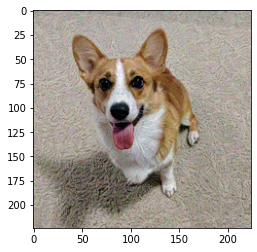

In [ ]:
# 시각화를 위해 넘파이 행렬 변환
perturbed_data_view = perturbed_data.squeeze(0).detach()
perturbed_data_view = perturbed_data_view.transpose(0,2).transpose(0,1).numpy()

plt.imshow(perturbed_data_view)

### 7-1-6. 원본과 적대적 예제 비교

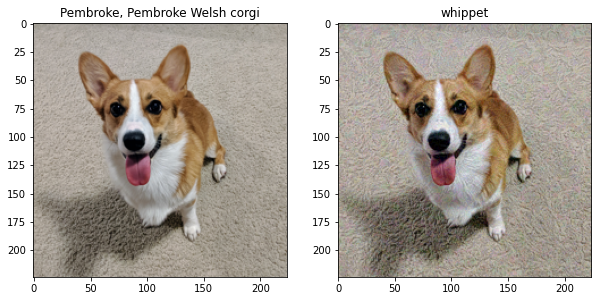

In [ ]:
f, a = plt.subplots(1, 2, figsize=(10, 10))

# 원본
a[0].set_title(prediction_name)
a[0].imshow(original_img_view)

# 적대적 예제
a[1].set_title(perturbed_prediction_name)
a[1].imshow(perturbed_data_view)

plt.show()

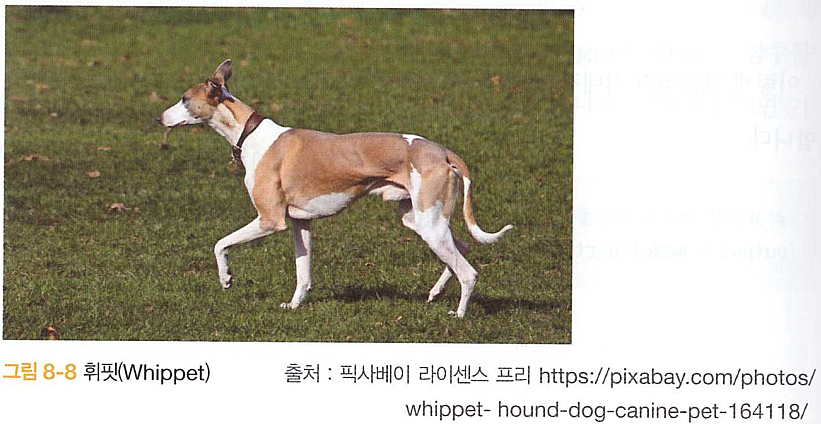